# Modeling using Boosters

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
%matplotlib inline

RANDOM_STATE = 42
class_names = ["A", "B", "None"]

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
train_df = pd.read_csv("working_data/trial_promo_training.csv")
val_df = pd.read_csv("working_data/trial_promo_testing.csv")

print("train_df shape", train_df.shape)
print("val_df shape", val_df.shape)

train_df shape (750, 34)
val_df shape (250, 34)


### Data balancing using equal classes strategy

In [4]:
should_balance = True

In [5]:
number_of_nones = train_df[train_df["decision"] == "None"].shape[0]
nones_df = train_df[train_df["decision"] == "None"]
productA_df = train_df[train_df["decision"] == "A"]
productB_df = train_df[train_df["decision"] == "B"]
print("Number of None's: " + str(nones_df.shape[0]))
print("Increase product A's by: " + str(number_of_nones - productA_df.shape[0]))
print("Increase product B's by: " + str(number_of_nones - productB_df.shape[0]))
print("Number of product A's: " + str(productA_df.shape[0]))
print("Number of product B's: " + str(productB_df.shape[0]))
times_to_increase_productA_df = (number_of_nones - productA_df.shape[0])//productA_df.shape[0]
times_to_increase_productB_df = (number_of_nones - productB_df.shape[0])//productB_df.shape[0]

Number of None's: 621
Increase product A's by: 521
Increase product B's by: 592
Number of product A's: 100
Number of product B's: 29


In [6]:
if should_balance:
    repeated_product_A = [productA_df] * times_to_increase_productA_df
    repeated_product_B = [productB_df] * times_to_increase_productB_df
    repeated_product_A_df = pd.concat(repeated_product_A)
    repeated_product_B_df = pd.concat(repeated_product_B)
    dfs_to_concat = [nones_df, repeated_product_A_df, repeated_product_B_df]
    train_df = pd.concat(dfs_to_concat)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print("New # rows: " + str(train_df.shape[0]))
    train_df.head()
else:
    print("Training data will not be balanced")

New # rows: 1701


In [7]:
feature_columns = ["age", "income", "avbal", "avtrans", "sexNum", "mstatusNum", "occupationNum", "educationNum", "childrenNum"]
target_column = ["decision"]
X_train = train_df.loc[:, feature_columns]
y_train = train_df.loc[:, target_column]
X_val = val_df.loc[:, feature_columns]
y_val = val_df.loc[:, target_column]
X_train.head(5)

,age,income,avbal,avtrans,sexNum,mstatusNum,occupationNum,educationNum,childrenNum
0,61.49,1376.26,12145.47,1235.43,1,1,6,2,4
1,28.05,7708.39,19249.76,2485.03,0,0,4,0,3
2,21.75,3086.05,10153.88,592.97,1,2,4,2,0
3,28.03,6163.24,11725.56,2001.96,0,2,0,3,0
4,68.84,3509.98,23594.99,948.18,1,1,8,3,1


## AdaBoost

In [8]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), algorithm="SAMME.R", n_estimators=200, random_state=RANDOM_STATE)

In [9]:
adaboost.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=42)

In [10]:
y_pred_ada = adaboost.predict(X_val)

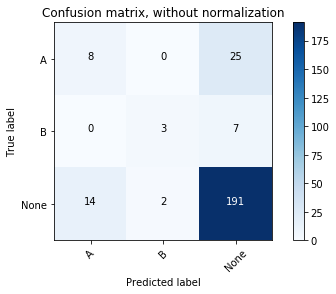

In [11]:
cnf_matrix_ada = confusion_matrix(y_val, y_pred_ada)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_ada, classes=class_names,
                      title='Confusion matrix, without normalization')

In [12]:
print("test accuracy:", accuracy_score(y_val, y_pred_ada))

test accuracy: 0.808


In [13]:
print("kappa score:", cohen_kappa_score(y_val, y_pred_ada))

kappa score: 0.22894043564865385


In [14]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred_ada, labels=class_names)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3636,0.2424,0.2909,33
B,0.6000,0.3000,0.4000,10
None,0.8565,0.9227,0.8884,207


## Gradient Boosting

In [15]:
gradientboost = GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=5, max_depth=None, random_state=RANDOM_STATE, min_samples_split=5)

In [16]:
gradientboost.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=None,
              max_features=None, max_leaf_nodes=5,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [17]:
y_pred_grad = adaboost.predict(X_val)

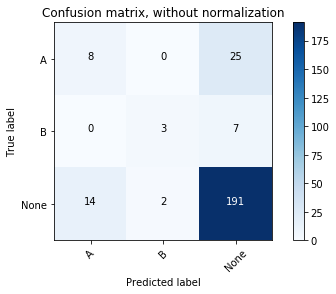

In [18]:
cnf_matrix_grad = confusion_matrix(y_val, y_pred_grad)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grad, classes=class_names,
                      title='Confusion matrix, without normalization')

In [19]:
print("test accuracy:", accuracy_score(y_val, y_pred_grad))

test accuracy: 0.808


In [20]:
print("kappa score:", cohen_kappa_score(y_val, y_pred_grad))

kappa score: 0.22894043564865385


In [21]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred_grad, labels=class_names)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3636,0.2424,0.2909,33
B,0.6000,0.3000,0.4000,10
None,0.8565,0.9227,0.8884,207


## XGBoost

In [22]:
xgb = XGBClassifier(n_jobs=10, max_depth=10, learning_rate=0.1, n_estimators=500, booster='gbtree', base_score=0.33, random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.33, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=10, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [23]:
y_pred_xgb = xgb.predict(X_val)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


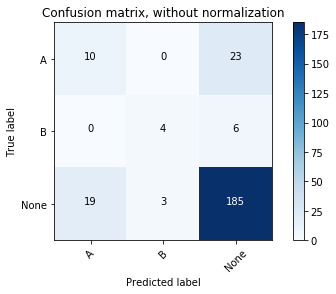

In [24]:
cnf_matrix_grad = confusion_matrix(y_val, y_pred_xgb)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grad, classes=class_names,
                      title='Confusion matrix, without normalization')

In [25]:
print("test accuracy:", accuracy_score(y_val, y_pred_xgb))

test accuracy: 0.796


In [26]:
print("kappa score:", cohen_kappa_score(y_val, y_pred_xgb))

kappa score: 0.25764192139737996


In [27]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred_xgb, labels=class_names)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3448,0.3030,0.3226,33
B,0.5714,0.4000,0.4706,10
None,0.8645,0.8937,0.8789,207
